In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

In [2]:
import pickle
import boto3
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

## Importamos la información

In [3]:
session = boto3.session.Session()
s3client = session.client('s3')

In [4]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/features_train.pkl')

body = response['Body'].read()
features_train = pickle.loads(body)

In [5]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/labels_train.pkl')

body = response['Body'].read()
labels_train = pickle.loads(body)

In [6]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/features_test.pkl')

body = response['Body'].read()
features_test = pickle.loads(body)

In [7]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/labels_test.pkl')

body = response['Body'].read()
labels_test = pickle.loads(body)

In [8]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/df.pkl')

body = response['Body'].read()
df = pickle.loads(body)

In [9]:
features_train.shape

(5783, 300)

In [10]:
features_test.shape

(1446, 300)

## Cross-Validation para tuneo de hyperparámetros

In [11]:
gb_0 = GradientBoostingClassifier(random_state=8)
pprint(gb_0.get_params())

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 8,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


**Busqueda aleatoria Cross Validation**

In [12]:
n_estimators = [200, 800]
max_features = ['auto', 'sqrt']

max_depth = [10, 40]
max_depth.append(None)

min_samples_split = [10, 30, 50]

min_samples_leaf = [1, 2, 4]

learning_rate = [.1, .5]

subsample = [.5, 1.]

random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'learning_rate': learning_rate,
              'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


In [13]:
gbc = GradientBoostingClassifier(random_state=8)

busqueda = RandomizedSearchCV(estimator=gbc,
                             param_distributions=random_grid,
                             n_jobs=-1,
                             n_iter=50,
                             scoring='accuracy',
                             cv=3,
                             verbose=1,
                             random_state=8)

busqueda.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 95.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [14]:
print(busqueda.best_params_)

{'subsample': 0.5, 'n_estimators': 200, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'learning_rate': 0.1}


In [15]:
print(busqueda.best_score_)

0.722981151651392


Acotamos nuestra busqueda considerando los valores encontrados.

**Grid Search Cross Validation**

In [16]:
max_depth = [5, 10, 15]
max_features = ['auto']
min_samples_leaf = [1]
min_samples_split = [30, 60]
n_estimators = [200]
learning_rate = [.1, .5]
subsample = [.5]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample
}

gbc = GradientBoostingClassifier(random_state=8)

cv_sets = ShuffleSplit(n_splits = 3, 
                       test_size = 0.33,
                      random_state = 8)

grid_search = GridSearchCV(estimator=gbc,
                          param_grid=param_grid,
                          scoring='accuracy',
                          cv=cv_sets,
                          verbose=1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  7.5min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_sa...
                                                  tol=0.0001,
                                                  validation_fraction=0.1,
                                                  verbose=0, warm_st

In [17]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 60, 'n_estimators': 200, 'subsample': 0.5}


In [18]:
print(grid_search.best_score_)

0.7234154007333683


**Modelo**

In [19]:
best_gbc = grid_search.best_estimator_

In [20]:
best_gbc

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=15,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=60,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=8, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

##  Fit y desempeño del modelo

Modelamos con la data de entrenamiento

In [21]:
best_gbc.fit(features_train, labels_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=15,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=60,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=8, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Predicciones

In [22]:
gbc_pred = best_gbc.predict(features_test)

**training accuracy**

In [23]:
print(accuracy_score(labels_train, best_gbc.predict(features_train)))

0.8808576863219783


**test accuracy**

In [24]:
print(accuracy_score(labels_test, gbc_pred))

0.6998616874135546


**classification report**

In [25]:
print(classification_report(labels_test, gbc_pred))

              precision    recall  f1-score   support

           0       0.63      0.64      0.64       593
           1       0.75      0.74      0.74       853

    accuracy                           0.70      1446
   macro avg       0.69      0.69      0.69      1446
weighted avg       0.70      0.70      0.70      1446



**confusion matrix**

<function matplotlib.pyplot.show(*args, **kw)>

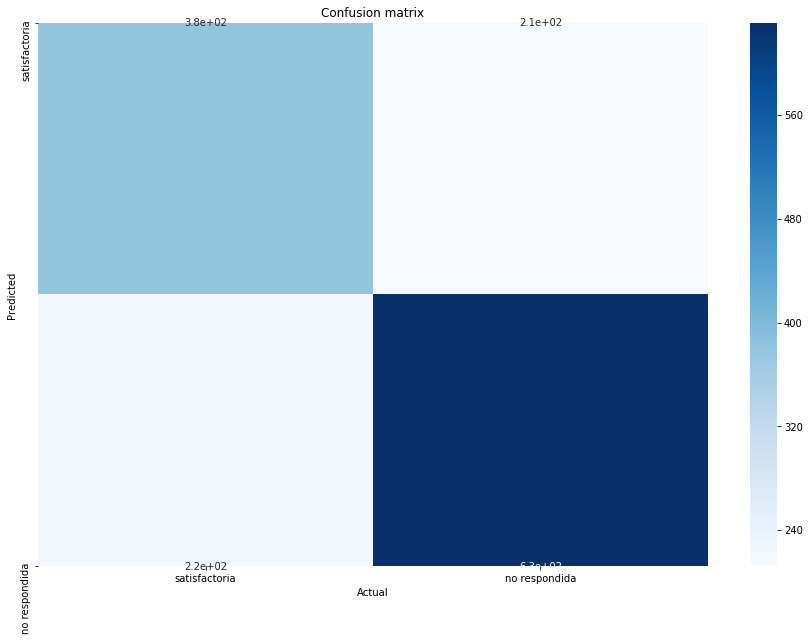

In [26]:
aux_df = df[['calidad_respuesta_real', 'codigo_calidad_respuesta_real']].drop_duplicates().sort_values('codigo_calidad_respuesta_real')
conf_matrix = confusion_matrix(labels_test, gbc_pred)
plt.figure(figsize=(15,10))
sns.heatmap(conf_matrix,
           annot=True,
           xticklabels=aux_df['calidad_respuesta_real'].values,
           yticklabels=aux_df['calidad_respuesta_real'].values,
           cmap='Blues')

plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show

Creamos un dataframe

In [27]:
data = {
    'Modelo': 'GBC',
    'Training Set Accuracy': accuracy_score(labels_train, best_gbc.predict(features_train)),
    'Test Set Accuracy': accuracy_score(labels_test, gbc_pred)
}
df_models_gbc = pd.DataFrame(data, index=[0])

In [28]:
df_models_gbc

,Modelo,Training Set Accuracy,Test Set Accuracy
0,GBC,0.880858,0.699862


## Guardamos en S3

In [29]:
bucket='inai-summerofdata'
key='modeling/GBC/0_year_dependencia/best_gbc.pkl'
pickle_byte_obj = pickle.dumps(best_gbc)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)

{'ResponseMetadata': {'RequestId': 'C1B9E95019D14CBA',
  'HostId': 'p3xn18eX1soCcP+i36KTvilxPpDgzz/ShtCzxzTU8BnooPR3RxgLWvtWrGEw9YqYjOcKDzqeurg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'p3xn18eX1soCcP+i36KTvilxPpDgzz/ShtCzxzTU8BnooPR3RxgLWvtWrGEw9YqYjOcKDzqeurg=',
   'x-amz-request-id': 'C1B9E95019D14CBA',
   'date': 'Thu, 23 Jul 2020 05:05:51 GMT',
   'etag': '"182f6c7b0c52737afb0527784a816f2a"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"182f6c7b0c52737afb0527784a816f2a"'}

In [30]:
bucket='inai-summerofdata'
key='modeling/GBC/0_year_dependencia/df_models_gbc.pkl'
pickle_byte_obj = pickle.dumps(df_models_gbc)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)

{'ResponseMetadata': {'RequestId': 'E476F6B450946D23',
  'HostId': 'Pgb5BWok+wTXsvIT7pOyNLGaxnkO5bFPHSB5J/eqbqdLYk+rsUrxFUPYSdPa9h5u2KfnfwbyU5Q=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Pgb5BWok+wTXsvIT7pOyNLGaxnkO5bFPHSB5J/eqbqdLYk+rsUrxFUPYSdPa9h5u2KfnfwbyU5Q=',
   'x-amz-request-id': 'E476F6B450946D23',
   'date': 'Thu, 23 Jul 2020 05:05:56 GMT',
   'etag': '"2c083f6b93886b5f838cf583ea7840cc"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"2c083f6b93886b5f838cf583ea7840cc"'}